In [ ]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import math
import pandas as pd

import os, re, time, math, tqdm, itertools
import seaborn as sns
import plotly.express as px
import plotly.offline as pyo

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

import keras
from keras.layers import Conv2D, Conv1D, MaxPooling2D, MaxPooling1D, Flatten, BatchNormalization, Dense
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.callbacks import CSVLogger, ModelCheckpoint

# Read CSV files and output feature info

In [ ]:
cic_dat_d1 = pd.read_csv('/content/drive/MyDrive/CIC_IDS_2018/02-14-2018.csv')
cic_dat_d2 = pd.read_csv('/content/drive/MyDrive/CIC_IDS_2018/02-15-2018.csv')
# cic_dat_d3 = pd.read_csv('/content/drive/MyDrive/CIC_IDS_2018/02-16-2018.csv')
# cic_dat_d4 = pd.read_csv('/content/drive/MyDrive/CIC_IDS_2018/02-20-2018.csv')
# cic_dat_d5 = pd.read_csv('/content/drive/MyDrive/CIC_IDS_2018/02-21-2018.csv')
# cic_dat_d6 = pd.read_csv('/content/drive/MyDrive/CIC_IDS_2018/02-22-2018.csv')
# cic_dat_d7 = pd.read_csv('/content/drive/MyDrive/CIC_IDS_2018/02-23-2018.csv')
# cic_dat_d8 = pd.read_csv('/content/drive/MyDrive/CIC_IDS_2018/02-28-2018.csv')
# cic_dat_d9 = pd.read_csv('/content/drive/MyDrive/CIC_IDS_2018/03-01-2018.csv')
# dataset0 = pd.read_csv('/content/drive/MyDrive/CIC_IDS_2018/03-02-2018.csv')

cic_dat_d1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 80 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   Dst Port           1048575 non-null  int64  
 1   Protocol           1048575 non-null  int64  
 2   Timestamp          1048575 non-null  object 
 3   Flow Duration      1048575 non-null  int64  
 4   Tot Fwd Pkts       1048575 non-null  int64  
 5   Tot Bwd Pkts       1048575 non-null  int64  
 6   TotLen Fwd Pkts    1048575 non-null  int64  
 7   TotLen Bwd Pkts    1048575 non-null  int64  
 8   Fwd Pkt Len Max    1048575 non-null  int64  
 9   Fwd Pkt Len Min    1048575 non-null  int64  
 10  Fwd Pkt Len Mean   1048575 non-null  float64
 11  Fwd Pkt Len Std    1048575 non-null  float64
 12  Bwd Pkt Len Max    1048575 non-null  int64  
 13  Bwd Pkt Len Min    1048575 non-null  int64  
 14  Bwd Pkt Len Mean   1048575 non-null  float64
 15  Bwd Pkt Len Std    1048575 non-n

In [ ]:
cic_dat_d2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 80 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   Dst Port           1048575 non-null  int64  
 1   Protocol           1048575 non-null  int64  
 2   Timestamp          1048575 non-null  object 
 3   Flow Duration      1048575 non-null  int64  
 4   Tot Fwd Pkts       1048575 non-null  int64  
 5   Tot Bwd Pkts       1048575 non-null  int64  
 6   TotLen Fwd Pkts    1048575 non-null  int64  
 7   TotLen Bwd Pkts    1048575 non-null  int64  
 8   Fwd Pkt Len Max    1048575 non-null  int64  
 9   Fwd Pkt Len Min    1048575 non-null  int64  
 10  Fwd Pkt Len Mean   1048575 non-null  float64
 11  Fwd Pkt Len Std    1048575 non-null  float64
 12  Bwd Pkt Len Max    1048575 non-null  int64  
 13  Bwd Pkt Len Min    1048575 non-null  int64  
 14  Bwd Pkt Len Mean   1048575 non-null  float64
 15  Bwd Pkt Len Std    1048575 non-n

In [ ]:
cic_dat_d1['Label'].value_counts()

Benign            667626
FTP-BruteForce    193360
SSH-Bruteforce    187589
Name: Label, dtype: int64

In [ ]:
cic_dat_d2['Label'].value_counts()

Benign                   996077
DoS attacks-GoldenEye     41508
DoS attacks-Slowloris     10990
Name: Label, dtype: int64

In [ ]:
dataset = pd.concat([cic_dat_d1, cic_dat_d2], axis =0)

In [ ]:
dataset['Label'].value_counts()

Benign                   1663703
FTP-BruteForce            193360
SSH-Bruteforce            187589
DoS attacks-GoldenEye      41508
DoS attacks-Slowloris      10990
Name: Label, dtype: int64

# Data Pre-processing

Remove categorical features for data cleaning

In [ ]:
dataset = dataset.drop(columns = ["Timestamp"], axis = 1)

# Change labels to corresponding integers
label_encoder = LabelEncoder()
dataset['Label']= label_encoder.fit_transform(dataset['Label'])
dataset['Label'].unique()

dataset['Label'].value_counts()

0    1663703
3     193360
4     187589
1      41508
2      10990
Name: Label, dtype: int64

Data cleaning

In [ ]:
dataset.isna().sum().to_numpy() # Number of N/A values in each feature

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0, 7198,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0])

In [ ]:
# Bound invalid values, N/A to feature minimum, Infinity to feature maximum
for column in dataset:
  dataset[column] = dataset[column].fillna(dataset[column].min())
  dataset[column] = dataset[column].replace(np.Infinity, (dataset[column]!=np.Infinity).max())


In [ ]:
dataset.isna().sum().to_numpy()

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
# Print variances of features to show constant value features to be removed
var_threshold = VarianceThreshold(threshold=0)   # threshold = 0 for constant
var_threshold.fit(dataset)

for i in range(len(var_threshold.feature_names_in_)):
  if var_threshold.variances_[i] == 0:
    dataset = dataset.drop(columns = [var_threshold.feature_names_in_[i]], axis = 1) # Drop any features with constant values across all samples
  print(var_threshold.feature_names_in_[i], var_threshold.variances_[i])

Dst Port 65534.0
Protocol 17.0
Flow Duration 919131000000.0
Tot Fwd Pkts 1560.641973615891
Tot Bwd Pkts 10287.378412111657
TotLen Fwd Pkts 8737314.0
TotLen Bwd Pkts 27905234.0
Fwd Pkt Len Max 64440.0
Fwd Pkt Len Min 481.46974229951
Fwd Pkt Len Mean 3261.7328121219684
Fwd Pkt Len Std 7799.596549134676
Bwd Pkt Len Max 2708.0
Bwd Pkt Len Min 1176.0
Bwd Pkt Len Mean 1459.240494732
Bwd Pkt Len Std 1329.3607486307
Flow Byts/s 1298500000.0
Flow Pkts/s 4000000.0010297606
Flow IAT Mean 340820991524.0
Flow IAT Std 424473900119.579
Flow IAT Max 1139219000000.0
Flow IAT Min 943683991524.0
Fwd IAT Tot 919130999899.0
Fwd IAT Mean 340820991524.0
Fwd IAT Std 424473900119.579
Fwd IAT Max 1139219000000.0
Fwd IAT Min 943683991524.0
Bwd IAT Tot 119999812.0
Bwd IAT Mean 119913081.0
Bwd IAT Std 84502515.871413
Bwd IAT Max 119913081.0
Bwd IAT Min 119913081.0
Fwd PSH Flags 0.03740168152237293
Bwd PSH Flags 0.0
Fwd URG Flags 0.0
Bwd URG Flags 0.0
Fwd Header Len 204920.0
Bwd Header Len 383632.0
Fwd Pkts/s 40000

In [ ]:
dataset.shape # Final samples and columns/features

(2097150, 69)

Organize data by classes

In [ ]:
# make 5 seperate datasets for 5 feature labels
data_1 = dataset[dataset['Label'] == 0]
data_2 = dataset[dataset['Label'] == 1]
data_3 = dataset[dataset['Label'] == 2]
data_4 = dataset[dataset['Label'] == 3]
data_5 = dataset[dataset['Label'] == 4]

Randomly resample class data for equal distribution

1.   Class 1 - Benign
2.   Class 2 - Dos-GoldenEye
3. Class 3 - Dos-Slowloris
4. Class 4 - FTP-Bruteforce
5. Class 5 - SSH-Bruteforce

In [ ]:
data_1_resample = resample(data_1, n_samples=40000, 
                           random_state=123, replace=True) # Benign
data_2_resample = resample(data_2, n_samples=10000, 
                           random_state=123, replace=True) # Dos-Attacks GoldenEye
data_3_resample = resample(data_3, n_samples=10000, 
                           random_state=123, replace=True) # Dos-Attacks Slowloris
data_4_resample = resample(data_4, n_samples=10000, 
                           random_state=123, replace=True) # FTP-Bruteforce
data_5_resample = resample(data_5, n_samples=10000, 
                           random_state=123, replace=True) # SSH-Bruteforce

# Organize Training and Testing splits (Choose one then head to the 'Setup Training and Testing data' step)

Baseline non-incremental

In [ ]:
train_dataset = [pd.concat([data_1_resample[0:8500], data_2_resample[0:8400], data_3_resample[0:300], data_4_resample[0:200], data_5_resample[0:100]])]
test_dataset = pd.concat([data_1_resample[36000:40000], data_2_resample[9000:10000], data_3_resample[9000:10000], data_4_resample[9000:10000], data_5_resample[9000:10000]])
target_train = []
target_test = test_dataset['Label']
X_train = []
y_train = []
y_test = to_categorical(target_test, num_classes=5)

Equal distribution between class-split tasks, 50:50 split b/w Benign and Attack for each

In [ ]:
train_dataset = [pd.concat([data_1_resample[0:9000], data_2_resample[0:9000]]), 
                 pd.concat([data_1_resample[9000:18000], data_3_resample[0:9000]]), 
                 pd.concat([data_1_resample[18000:27000], data_4_resample[0:9000]]), 
                 pd.concat([data_1_resample[27000:36000], data_5_resample[0:9000]])]
test_dataset = pd.concat([data_1_resample[36000:40000], data_2_resample[9000:10000], data_3_resample[9000:10000], data_4_resample[9000:10000], data_5_resample[9000:10000]])
target_train = []
target_test = test_dataset['Label']
X_train = []
y_train = []
y_test = to_categorical(target_test, num_classes=5)

Larger Base training task, smaller increment tasks, 50:50 split b/w Benign and Attack for each

In [ ]:
train_dataset = [pd.concat([data_1_resample[0:9000], data_2_resample[0:9000]]), 
                 pd.concat([data_1_resample[9000:13500], data_3_resample[0:4500]]), 
                 pd.concat([data_1_resample[13500:18000], data_4_resample[0:4500]]), 
                 pd.concat([data_1_resample[18000:22500], data_5_resample[0:4500]])]
test_dataset = pd.concat([data_1_resample[36000:40000], data_2_resample[9000:10000], data_3_resample[9000:10000], data_4_resample[9000:10000], data_5_resample[9000:10000]])
target_train = []
target_test = test_dataset['Label']
X_train = []
y_train = []
y_test = to_categorical(target_test, num_classes=5)

Larger Base training task, much smaller increment tasks, 50:50 split b/w Benign and Attack for each

In [ ]:
train_dataset = [pd.concat([data_1_resample[0:9000], data_2_resample[0:9000]]), 
                 pd.concat([data_1_resample[9000:10000], data_3_resample[0:1000]]), 
                 pd.concat([data_1_resample[10000:11000], data_4_resample[0:1000]]), 
                 pd.concat([data_1_resample[11000:12000], data_5_resample[0:1000]])]
test_dataset = pd.concat([data_1_resample[36000:40000], data_2_resample[9000:10000], data_3_resample[9000:10000], data_4_resample[9000:10000], data_5_resample[9000:10000]])
target_train = []
target_test = test_dataset['Label']
X_train = []
y_train = []
y_test = to_categorical(target_test, num_classes=5)

Learned class data mixed into each task (1000 samples each)

In [ ]:
baseline = 0
train_dataset = [pd.concat([data_1_resample[0:9000], data_2_resample[0:9000]]), 
                 pd.concat([data_1_resample[9000:13500], data_3_resample[0:4500], data_2_resample[0:1000]]), 
                 pd.concat([data_1_resample[13500:18000], data_4_resample[0:4500], data_2_resample[0:1000], data_3_resample[0:1000]]), 
                 pd.concat([data_1_resample[18000:22500], data_5_resample[0:4500], data_4_resample[0:1000], data_2_resample[0:1000], data_3_resample[0:1000]])]
test_dataset = pd.concat([data_1_resample[36000:40000], data_2_resample[9000:10000], data_3_resample[9000:10000], data_4_resample[9000:10000], data_5_resample[9000:10000]])
target_train = []
target_test = test_dataset['Label']
X_train = []
y_train = []
y_test = to_categorical(target_test, num_classes=5)

Learned class data mixed into each task (500 samples each)

In [ ]:
train_dataset = [pd.concat([data_1_resample[0:9000], data_2_resample[0:9000]]), 
                 pd.concat([data_1_resample[9000:13500], data_3_resample[0:4500], data_2_resample[0:500]]), 
                 pd.concat([data_1_resample[13500:18000], data_4_resample[0:4500], data_2_resample[0:500], data_3_resample[0:500]]), 
                 pd.concat([data_1_resample[18000:22500], data_5_resample[0:4500], data_4_resample[0:500], data_2_resample[0:500], data_3_resample[0:500]])]
test_dataset = pd.concat([data_1_resample[36000:40000], data_2_resample[9000:10000], data_3_resample[9000:10000], data_4_resample[9000:10000], data_5_resample[9000:10000]])
target_train = []
target_test = test_dataset['Label']
X_train = []
y_train = []
y_test = to_categorical(target_test, num_classes=5)

Learned class data mixed into each task (short increments of 100 with equal data mixed in)

In [ ]:
train_dataset = [pd.concat([data_1_resample[0:8000], data_2_resample[0:8000]]), 
                 pd.concat([data_1_resample[9000:9100], data_3_resample[0:100], data_2_resample[8000:8100]]), 
                 pd.concat([data_1_resample[9100:9200], data_4_resample[0:100], data_2_resample[8100:8200], data_3_resample[100:200]]), 
                 pd.concat([data_1_resample[9200:9300], data_5_resample[0:100], data_4_resample[100:200], data_2_resample[8200:8300], data_3_resample[200:300]])]
test_dataset = pd.concat([data_1_resample[36000:40000], data_2_resample[9000:10000], data_3_resample[9000:10000], data_4_resample[9000:10000], data_5_resample[9000:10000]])
target_train = []
target_test = test_dataset['Label']
X_train = []
y_train = []
y_test = to_categorical(target_test, num_classes=5)

Setup training and testing data

In [ ]:
i = 0
for task in train_dataset:
  task = task.sample(frac=1)
  target_train.append(task['Label'])

  y_train.append(to_categorical(target_train[i], num_classes=5))
  task = task.drop(columns = ["Label"], axis=1)

  X_train.append(task.iloc[:, :-1].values)

  X_train[i] = np.asarray(X_train[i]).astype(np.float32)

  # reshape the data for CNN
  X_train[i] = X_train[i].reshape(len(X_train[i]), X_train[i].shape[1], 1)

  i+=1

test_dataset = test_dataset.drop(columns = ["Label"], axis=1)

X_test = test_dataset.iloc[:, :-1].values
X_test = np.asarray(X_test).astype(np.float32)
X_test = X_test.reshape(len(X_test), X_test.shape[1], 1)

X_train[0].shape, X_train[1].shape, X_train[2].shape, X_train[3].shape, X_test.shape #If using Baseline, only print the first X_train element since theres only one task with all classes

# CNN model

In [ ]:
# making the deep learning function
def model():
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=6, activation='relu', 
                    padding='same', input_shape=(67, 1)))
    model.add(BatchNormalization())
    
    # adding a pooling layer
    model.add(MaxPooling1D(pool_size=(3), strides=2, padding='same'))
    
    model.add(Conv1D(filters=64, kernel_size=6, activation='relu', 
                    padding='same', input_shape=(67, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=(3), strides=2, padding='same'))
    
    model.add(Conv1D(filters=64, kernel_size=6, activation='relu', 
                    padding='same', input_shape=(67, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=(3), strides=2, padding='same'))
    
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(5, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model = model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 67, 64)            448       
                                                                 
 batch_normalization_3 (Batc  (None, 67, 64)           256       
 hNormalization)                                                 
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 34, 64)           0         
 1D)                                                             
                                                                 
 conv1d_4 (Conv1D)           (None, 34, 64)            24640     
                                                                 
 batch_normalization_4 (Batc  (None, 34, 64)           256       
 hNormalization)                                                 
                                                      

# Train model

Task 1

In [ ]:
logger = CSVLogger('logs.csv', append=True)
his = model.fit(X_train[0], y_train[0], epochs=10, batch_size=32, validation_split=0.1,
           callbacks=[logger])


Epoch 1/10
493/493 [==============================] - 12s 20ms/step - loss: 0.3044 - accuracy: 0.9060 - val_loss: 0.2404 - val_accuracy: 0.9274
Epoch 2/10
493/493 [==============================] - 10s 20ms/step - loss: 0.1626 - accuracy: 0.9483 - val_loss: 0.1432 - val_accuracy: 0.9400
Epoch 3/10
493/493 [==============================] - 9s 19ms/step - loss: 0.1304 - accuracy: 0.9588 - val_loss: 0.1595 - val_accuracy: 0.9537
Epoch 4/10
493/493 [==============================] - 9s 19ms/step - loss: 0.0904 - accuracy: 0.9728 - val_loss: 0.5071 - val_accuracy: 0.7497
Epoch 5/10
493/493 [==============================] - 9s 19ms/step - loss: 0.0793 - accuracy: 0.9750 - val_loss: 0.0531 - val_accuracy: 0.9846
Epoch 6/10
493/493 [==============================] - 9s 19ms/step - loss: 0.0598 - accuracy: 0.9813 - val_loss: 0.2676 - val_accuracy: 0.9469
Epoch 7/10
493/493 [==============================] - 10s 21ms/step - loss: 0.0659 - accuracy: 0.9818 - val_loss: 0.1573 - val_accuracy: 0.9

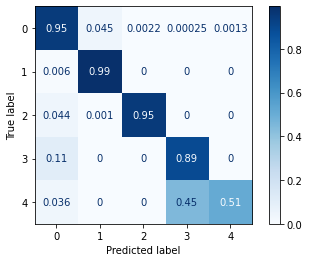

In [ ]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_pred = np.transpose(y_pred, axes=None)

plt = ConfusionMatrixDisplay.from_predictions(target_test, y_pred, normalize='true', cmap='Blues')

Task 2

In [ ]:
logger = CSVLogger('logs.csv', append=True)
his = model.fit(X_train[1], y_train[1], epochs=10, batch_size=32, validation_split=0.1,
           callbacks=[logger])


Epoch 1/10
268/268 [==============================] - 5s 19ms/step - loss: 0.2881 - accuracy: 0.9200 - val_loss: 0.0998 - val_accuracy: 0.9653
Epoch 2/10
268/268 [==============================] - 5s 19ms/step - loss: 0.0808 - accuracy: 0.9735 - val_loss: 0.0701 - val_accuracy: 0.9737
Epoch 3/10
268/268 [==============================] - 6s 21ms/step - loss: 0.0698 - accuracy: 0.9779 - val_loss: 0.0842 - val_accuracy: 0.9811
Epoch 4/10
268/268 [==============================] - 5s 19ms/step - loss: 0.0565 - accuracy: 0.9827 - val_loss: 0.2040 - val_accuracy: 0.8632
Epoch 5/10
268/268 [==============================] - 5s 19ms/step - loss: 0.0473 - accuracy: 0.9856 - val_loss: 0.0493 - val_accuracy: 0.9821
Epoch 6/10
268/268 [==============================] - 5s 19ms/step - loss: 0.0398 - accuracy: 0.9865 - val_loss: 0.0501 - val_accuracy: 0.9789
Epoch 7/10
268/268 [==============================] - 5s 19ms/step - loss: 0.0417 - accuracy: 0.9854 - val_loss: 0.0382 - val_accuracy: 0.9874

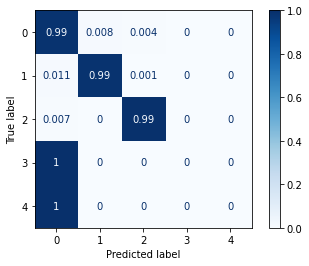

In [ ]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_pred = np.transpose(y_pred, axes=None)

plt = ConfusionMatrixDisplay.from_predictions(target_test, y_pred, normalize='true', cmap='Blues')

Task 3

In [ ]:
logger = CSVLogger('logs.csv', append=True)
his = model.fit(X_train[2], y_train[2], epochs=10, batch_size=32, validation_split=0.1,
           callbacks=[logger])

Epoch 1/10
282/282 [==============================] - 5s 19ms/step - loss: 0.2748 - accuracy: 0.9270 - val_loss: 0.1332 - val_accuracy: 0.9590
Epoch 2/10
282/282 [==============================] - 5s 18ms/step - loss: 0.0820 - accuracy: 0.9732 - val_loss: 0.0617 - val_accuracy: 0.9740
Epoch 3/10
282/282 [==============================] - 5s 18ms/step - loss: 0.0698 - accuracy: 0.9759 - val_loss: 0.0590 - val_accuracy: 0.9830
Epoch 4/10
282/282 [==============================] - 5s 19ms/step - loss: 0.0601 - accuracy: 0.9791 - val_loss: 0.0375 - val_accuracy: 0.9860
Epoch 5/10
282/282 [==============================] - 5s 18ms/step - loss: 0.0504 - accuracy: 0.9839 - val_loss: 0.0611 - val_accuracy: 0.9770
Epoch 6/10
282/282 [==============================] - 5s 19ms/step - loss: 0.0540 - accuracy: 0.9816 - val_loss: 0.0629 - val_accuracy: 0.9820
Epoch 7/10
282/282 [==============================] - 5s 19ms/step - loss: 0.0450 - accuracy: 0.9852 - val_loss: 0.0400 - val_accuracy: 0.9780

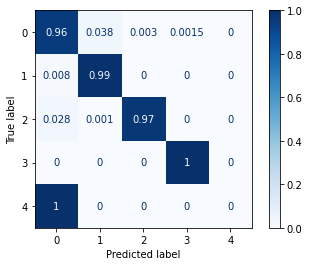

In [ ]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_pred = np.transpose(y_pred, axes=None)

plt = ConfusionMatrixDisplay.from_predictions(target_test, y_pred, normalize='true', cmap='Blues')

Task 4

In [ ]:
logger = CSVLogger('logs.csv', append=True)
his = model.fit(X_train[3], y_train[3], epochs=10, batch_size=32, validation_split=0.1,
           callbacks=[logger])

Epoch 1/10
296/296 [==============================] - 6s 19ms/step - loss: 0.3740 - accuracy: 0.9039 - val_loss: 0.1526 - val_accuracy: 0.9581
Epoch 2/10
296/296 [==============================] - 6s 19ms/step - loss: 0.0920 - accuracy: 0.9720 - val_loss: 0.1898 - val_accuracy: 0.9352
Epoch 3/10
296/296 [==============================] - 6s 20ms/step - loss: 0.0578 - accuracy: 0.9811 - val_loss: 0.1644 - val_accuracy: 0.9552
Epoch 4/10
296/296 [==============================] - 5s 19ms/step - loss: 0.0533 - accuracy: 0.9833 - val_loss: 0.0761 - val_accuracy: 0.9743
Epoch 5/10
296/296 [==============================] - 5s 18ms/step - loss: 0.0446 - accuracy: 0.9857 - val_loss: 0.0695 - val_accuracy: 0.9800
Epoch 6/10
296/296 [==============================] - 6s 19ms/step - loss: 0.0421 - accuracy: 0.9862 - val_loss: 0.0633 - val_accuracy: 0.9810
Epoch 7/10
296/296 [==============================] - 6s 19ms/step - loss: 0.0427 - accuracy: 0.9857 - val_loss: 0.0841 - val_accuracy: 0.9733

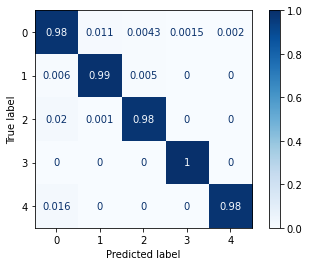

In [ ]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_pred = np.transpose(y_pred, axes=None)

plt = ConfusionMatrixDisplay.from_predictions(target_test, y_pred, normalize='true', cmap='Blues')

# Test model

In [ ]:
# check the model performance on test data
scores = model.evaluate(X_test, y_test)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1] * 100))

250/250 [==============================] - 1s 6ms/step - loss: 0.0138 - accuracy: 0.9964
accuracy: 99.64%


# Performance scores

In [ ]:
_, accuracy = model.evaluate(X_test, y_test)
print("\nEvaluation Metrics")
print("---------------------")
print("Accuracy = {} %" .format(accuracy*100))
print("Precision = {} %" .format(precision_score(target_test, y_pred, average="macro")*100))
print("Recall = {} %" .format(recall_score(target_test, y_pred, average="macro")*100))
print("F1 Score = {} %" .format(f1_score(target_test, y_pred, average="macro")*100))